<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Robot-class" data-toc-modified-id="Robot-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>Robot</code> class</a></span></li><li><span><a href="#Reinforcement-Learning-Problem-for-Controlling-the-Robot" data-toc-modified-id="Reinforcement-Learning-Problem-for-Controlling-the-Robot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reinforcement Learning Problem for Controlling the Robot</a></span></li><li><span><a href="#Reinforcement-Learning-Training-Algorithm" data-toc-modified-id="Reinforcement-Learning-Training-Algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reinforcement Learning Training Algorithm</a></span></li><li><span><a href="#Required-Experiments" data-toc-modified-id="Required-Experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Required Experiments</a></span><ul class="toc-item"><li><span><a href="#Good-parameter-values" data-toc-modified-id="Good-parameter-values-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Good parameter values</a></span></li><li><span><a href="#Create-robot-with-four-links-of-lengths,-4,-3,-3,--and-2." data-toc-modified-id="Create-robot-with-four-links-of-lengths,-4,-3,-3,--and-2.-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Create robot with four links of lengths, 4, 3, 3,  and 2.</a></span></li><li><span><a href="#Increase-number-of-valid-actions" data-toc-modified-id="Increase-number-of-valid-actions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Increase number of valid actions</a></span></li></ul></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=5>A6.1 Reinforcement Learning to Control a Robot</font>

* *A6.1:* To help you test your code, I added a call to `np.random.seed` to allow you to compare your output with mine.  At start of Section 4, I added a statement saying that you must discuss what you observe in the results.  Also added an argument to the `Robot.animate` function to allow you to draw one plot to visualize the trained robot's behavior.  

SURAJ ESWARAN

In this assignment, you will play with a simulation of a two-dimensional robot arm with multiple links and joints. You will train a neural network to approximate the Q function.

The state of the arm is just the angles of each joint.  To remove the huge difference between joint angles of 359 degrees and 1 degree as a joint moves, we will represent each joint angle with two values, the sine and cosine of the angle, as the state input to the neural network. Valid actions on each step will be $-0.1$, $0$, and $+0.1$ applied to each joint.

# `Robot` class

Here is an implementation of the robot simulation.

In [483]:
import numpy as np
import copy
import matplotlib.pyplot as plt
#import sys
import itertools  # for product (cross product)Itertools s a useful package for dealing with comobinations, permutatons and all kinds of things with iterative tools  
from math import pi
from IPython.display import display, clear_output #For doing some animations

Now import your `NeuralNetwork` regression class that uses `numpy` and has the `scg` optimizer available.

In [484]:
import A3mysolution as nn  # where you implement the NeuralNetwork class

In [485]:

class Robot():

    def __init__(self, link_lengths):
        #The constructor requires one argument which is just a list of length of each link.  
        self.n_links = len(link_lengths)
        self.record_angles = False
        self.angles = [] #The angles are actual state of thing. Initially it is an empty list. 
        self.link_lengths = np.array(link_lengths) #The lengths of link is saving away as a member variable
        self.joint_angles = np.zeros(self.n_links) #The joint anles will be zeros to begin with. 
        self.points = [[10, 10] for _ in range(self.n_links + 1)] #Points are which each joint occurs in the two dimensional coordinate system we are working with. Here we are just initializing points here
        #self.lim = sum(link_lengths)
        self.update_points() #Update points
        self.goal = None #Goal is a two dimensionalcoordinates 

    def set_goal(self, g):
        self.goal = g

    def dist_to_goal(self):
        #Calculates the distance to the goal from the end_effector is 
        return np.sqrt(np.sum((self.goal - self.end_effector)**2))
    
    def update_joints(self, joint_angles):
        #Update joints specfies them to particular angles
        self.joint_angles = joint_angles
        self.update_points()

    def add_to_joints(self, joint_angle_deltas):
        #add_to_joints is the action that takes places to update the joints 
        self.joint_angles += joint_angle_deltas
        too_high = self.joint_angles > 2 * pi
        self.joint_angles[too_high] = self.joint_angles[too_high] - 2 * pi
        too_low = self.joint_angles < 0
        self.joint_angles[too_low] = self.joint_angles[too_low] + 2 * pi
        if self.record_angles:
            self.angles.append(self.joint_angles * 180 / pi)
        self.update_points()

    def update_points(self):
        #Update_points with the given angles, we need to be able to calculate where each joint so that we can draw that. It is done with the help of trigonometry.  
        for i in range(1, self.n_links + 1):
            self.points[i][0] = (self.points[i - 1][0]
                                 + self.link_lengths[i - 1] * np.cos(np.sum(self.joint_angles[:i])))
            self.points[i][1] = (self.points[i - 1][1] +
                                 self.link_lengths[i - 1] * np.sin(np.sum(self.joint_angles[:i])))
        self.end_effector = np.array(self.points[self.n_links]).T  #end_effector is the value coordinates for the points for the last link. n_links is the number of links.

    def get_angles(self):
        return self.joint_angles
    

    def plot(self, style):
        for i in range(self.n_links + 1):
            if i is not self.n_links:
                plt.plot([self.points[i][0], self.points[i + 1][0]],
                         [self.points[i][1], self.points[i + 1][1]], style)
            plt.plot(self.points[i][0], self.points[i][1], 'k.')
        plt.axis('off')
        plt.axis('square')
        plt.xlim([-1, 21])
        plt.ylim([-1, 21])

    def animate(self, n_steps, Qnet=None, show_all_steps=False):
        fig = plt.figure(figsize=(8, 8))
        
        for i in range(n_steps):
            if not show_all_steps:
                fig.clf()
            plt.scatter(self.goal[0], self.goal[1], s=80)
            if Qnet:
                action, Qvalue = epsilon_greedy(self, Qnet, valid_actions, epsilon=0)
            else:
                action = [0.1] * self.n_links
            self.add_to_joints(action)
            style = 'b-' if show_all_steps and i+1 == n_steps else 'r-'
            self.plot(style)
            
            if not show_all_steps:
                clear_output(wait=True)
                display(fig)
            
        if not show_all_steps:
            clear_output(wait=True)

To use this class, first instantiate a robot by specifying the number of links and the lengths of each link as a list.  Imagine the end of the last link of the robot has a gripper. Set the goal location for the gripper by calling `robot.set_goal()`.  

Then you can animate the robot for some number of steps.

 By calling the constructor, we were instantiate a robot.

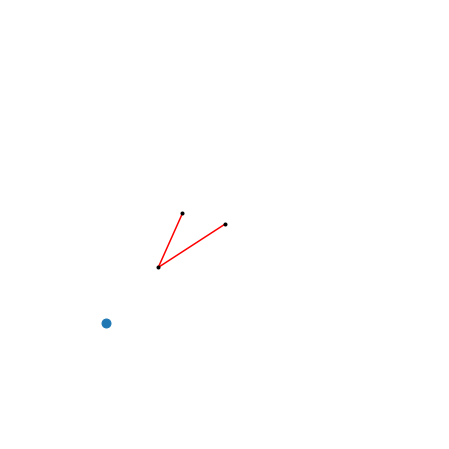

In [432]:
robot = Robot([4, 3]) #This makes a robot woth two links in it. Length of four for the first one from the shoulder and length of three from elbow out to the gripper. 
robot.set_goal([4, 5]) #We will set the goal to be at 4,5 and animate this thing for four steps.
robot.animate(100)

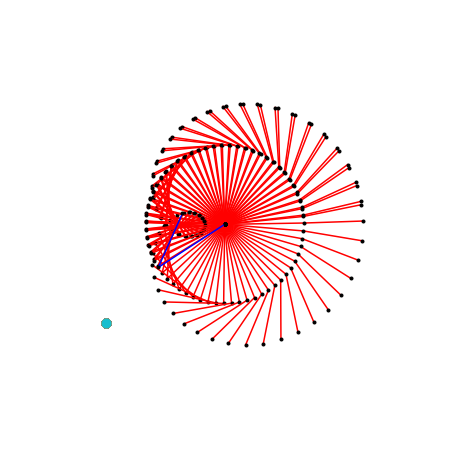

In [433]:
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100, show_all_steps=True)

# Reinforcement Learning Problem for Controlling the Robot

To define the reinforcement learning problem for controlling this robot, and trying to move the gripper as close to the goal as you can, we need to define the three main functions that define a reinforcement learning problem.  These are pretty easy with the functions available to us in the `Robot` class.  We will also need a function to represent the joint angles as sines and cosines.

In [486]:
def angles_to_sin_cos(angles):
    #Converting angles to sine cosine representation so that we get angles from our robot
    return np.hstack((np.sin(angles), np.cos(angles))) #Horizondally stack them into one flat vector numpy array.So all the signs comes first, then all the cosines comes next.  


def initial_state(robot):
    #Initial_state of the robot is just generated by picking a random number between minus 2pi and plus 2pi. One for each link and update the joints for those values. 
    robot.update_joints(np.random.uniform(-2 * pi, 2 * pi, size=(robot.n_links))) 
    angles = robot.get_angles() #
    state = angles_to_sin_cos(angles)
    return state


def next_state(robot, action):
    #We want to add a certain action to the joint which is going to be delta radiance for each joint  
    robot.add_to_joints(action)
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def reinforcement(robot):
    '''Objective is to move gripper to the goal location as quickly as possible.'''
    dist_to_goal = robot.dist_to_goal()
    return dist_to_goal

In [435]:
angles_to_sin_cos([0, pi/4, pi/2, pi, -pi])

array([ 0.00000000e+00,  7.07106781e-01,  1.00000000e+00,  1.22464680e-16,
       -1.22464680e-16,  1.00000000e+00,  7.07106781e-01,  6.12323400e-17,
       -1.00000000e+00, -1.00000000e+00])

In [436]:
initial_state(robot)

array([ 0.92434724,  0.41469317, -0.38155232, -0.90996131])

In [437]:
next_state(robot, [-1, 1])

array([ 0.82049215, -0.54164636,  0.57165779, -0.84060646])

In [438]:
reinforcement(robot)

9.736727837575186

Now we need our two workhorse functions, `epsilon_greedy` and `make_samples`.

In [487]:
def epsilon_greedy(robot, Qnet, valid_actions, epsilon): 
    #We need the robot because we need to get the angle from the current state
    state = angles_to_sin_cos(robot.get_angles())
    
    if np.random.uniform() < epsilon:
        
        # Random Move
        actioni = np.random.randint(valid_actions.shape[0])
        action = valid_actions[actioni]
        
    else:
        # Greedy Move
        
        Qs = [Qnet.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
        ai = np.argmin(Qs)
        action = valid_actions[ai]
        
    Q = Qnet.use(np.hstack((state, action)).reshape((1, -1)))
    
    return action, Q

In [488]:
def make_samples(robot, Qnet, initial_state_f, next_state_f, reinforcement_f,
                 valid_actions, n_samples, epsilon):

    #Initilize the data structure for the inputs to the neural network
    X = np.zeros((n_samples, Qnet.n_inputs))
    R = np.zeros((n_samples, 1))
    Qn = np.zeros((n_samples, 1))

    state = initial_state_f(robot)
    state = next_state_f(robot, [0] * robot.n_links)  # 0 action for all joints
    action, _ = epsilon_greedy(robot, Qnet, valid_actions, epsilon)

    # Collect data from numSamples steps
    for step in range(n_samples):
        
        next_state = next_state_f(robot, action)
        r = reinforcement_f(robot)
        next_action, next_Q = epsilon_greedy(robot, Qnet, valid_actions, epsilon)
        
        #Fill the reinforcement value and Q value with the environment
        X[step, :] = np.hstack((state, action))
        R[step, 0] = r
        Qn[step, 0] = next_Q
        
        # Advance one time step
        state, action = next_state, next_action

    return (X, R, Qn)

# Reinforcement Learning Training Algorithm

In [489]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    #Create our standarization parameters
    Qnet.stand_params = {}
    Qnet.stand_params['Xmeans'] = np.array(Xmeans)
    Qnet.stand_params['Xstds'] = np.array(Xstds)
    Qnet.stand_params['Tmeans'] = np.array(Tmeans)
    Qnet.stand_params['Tstds'] = np.array(Tstds)


def train(robot, n_hiddens_list, valid_actions, n_trials, n_steps_per_trial, n_scg_iterations,
          final_epsilon, gamma=0.8):

    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials))  # to produce this final value

    n_inputs = robot.n_links * 2 + robot.n_links
    
    Qnet = nn.NeuralNetwork(n_inputs, n_hiddens_list, 1) #Creating a neural network with right number of inputs

    means_state = [0] * robot.n_links * 2
    means_actions = [0] * robot.n_links
    stds_states = [0.5] * robot.n_links * 2
    stds_actions = [1.0] * robot.n_links
    setup_standardization(Qnet, means_state + means_actions, stds_states + stds_actions, [0], [1])

    epsilon = 1         # initial epsilon value
    epsilon_trace = []
    r_mean_trace = []
    r_trace = []
    for trial in range(n_trials):

        # Collect n_steps_per_trial samples
        X,R,Qn = make_samples(robot,Qnet,initial_state,next_state,reinforcement,valid_actions,n_steps_per_trial,epsilon)
        
        # Train Qnet on these samples for n_scg_iterations
        Qnet.train(X,R+gamma*Qn,n_epochs=n_scg_iterations,verbose=False)
        
        # Update the three traces
        epsilon_trace.append(epsilon)
        r_mean_trace.append(np.mean(R))
        r_trace.extend(R[:,0])
      
        # Decay epsilon
        epsilon *=epsilon_decay
        
        
        if trial + 1 == n_trials or (trial + 1) % (n_trials // 10) == 0:
            print(f'Trial {trial+1}: Mean R {r_mean_trace[-1]:.2f}')
             
    return Qnet, r_mean_trace, r_trace, epsilon_trace

In [450]:
single_joint_actions = [-0.1, 0, 0.1] #Set of actions for the whole robot that has every combinations of these numbers for each joint. 
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links))) #Iertools_Product is like a cartesian product 

In [443]:
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

In [444]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 8.55
Trial 40: Mean R 7.17
Trial 60: Mean R 7.38
Trial 80: Mean R 7.23
Trial 100: Mean R 3.78
Trial 120: Mean R 1.78
Trial 140: Mean R 1.19
Trial 160: Mean R 1.26
Trial 180: Mean R 1.32
Trial 200: Mean R 0.90


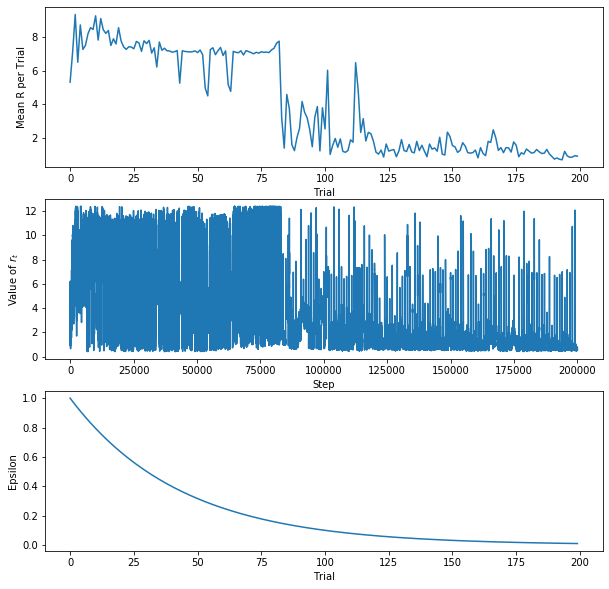

In [123]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

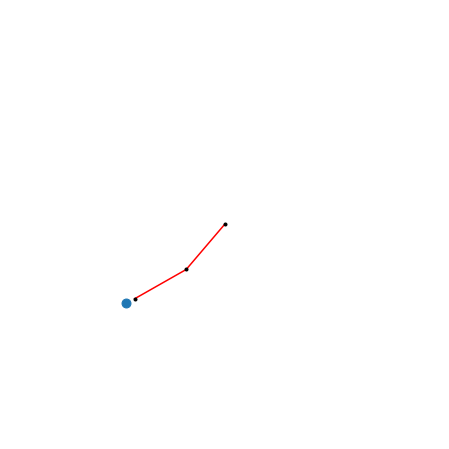

In [124]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

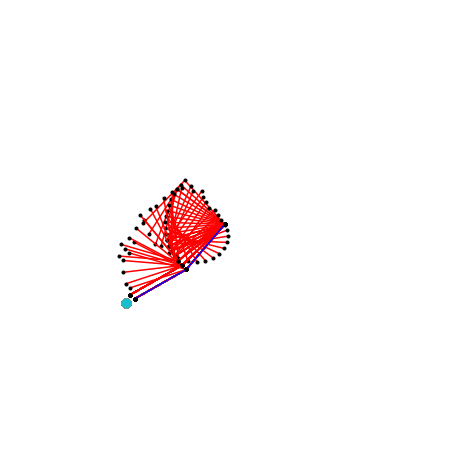

In [125]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

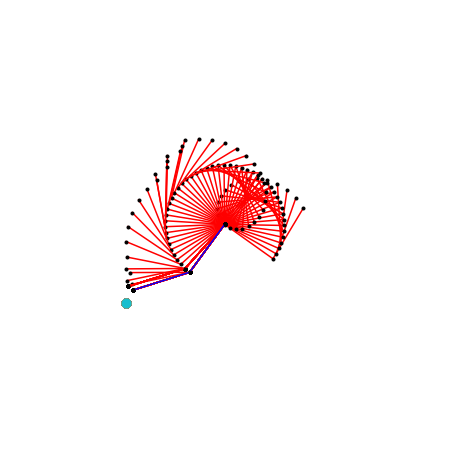

In [62]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

# Required Experiments

Show the results and discuss what you see. Which parameter values result in the best performance during and at the end of training?

## Good parameter values

Find values for parameters `n_hiddens_list`, `n_trials`, `n_steps_per_trial`, `n_scg_iterations`, and `gamma` that result in Mean R per Trial plot that shows fairly steady decrease to value close to 0. 

#### Experiment with parameters like number of trials, number of steps per trial, number of SCG iterations in each train call, and gamma.

##### 1. NUMBER OF TRAILS

Experiment 1

In [163]:
n_hiddens_list = [50, 10]
n_trials = 2000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 200: Mean R 1.17
Trial 400: Mean R 0.74
Trial 600: Mean R 0.80
Trial 800: Mean R 0.56
Trial 1000: Mean R 0.67
Trial 1200: Mean R 0.48
Trial 1400: Mean R 0.50
Trial 1600: Mean R 0.62
Trial 1800: Mean R 0.65
Trial 2000: Mean R 0.56


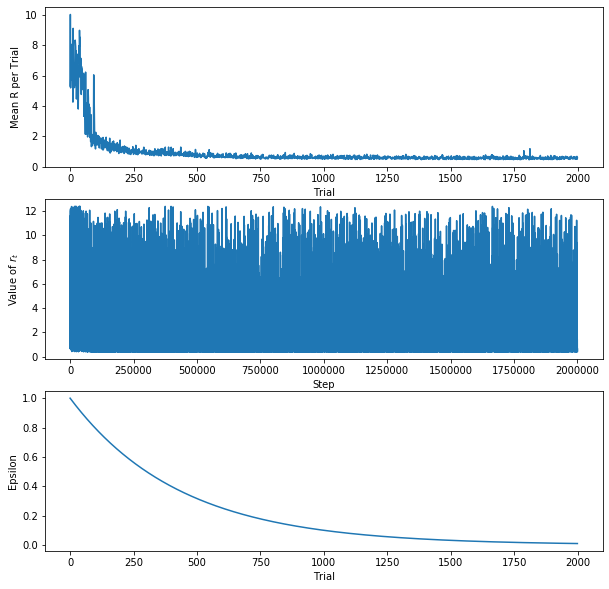

In [164]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

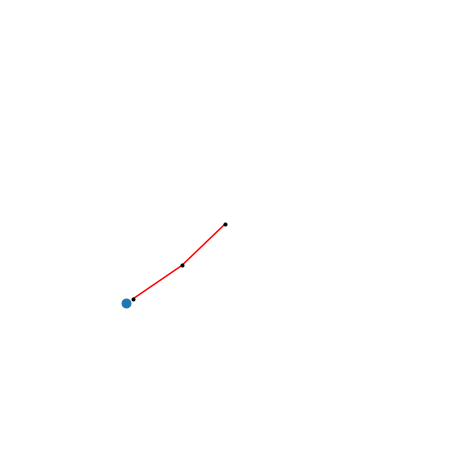

In [165]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

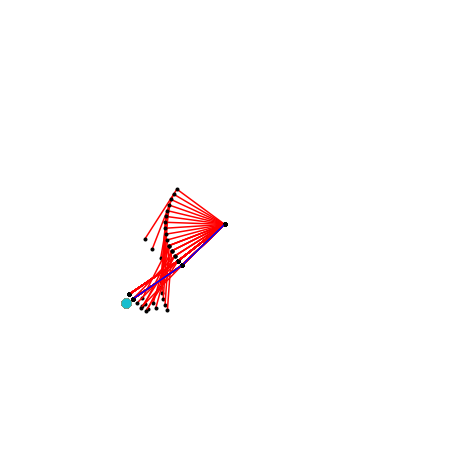

In [166]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

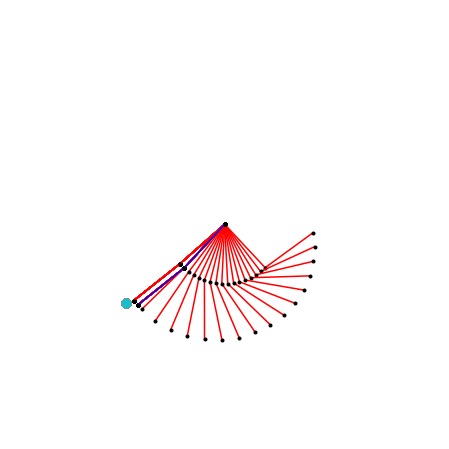

In [167]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

Experiment 2

In [168]:
n_hiddens_list = [50, 10]
n_trials = 5000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 500: Mean R 0.85
Trial 1000: Mean R 0.70
Trial 1500: Mean R 0.64
Trial 2000: Mean R 0.57
Trial 2500: Mean R 0.45
Trial 3000: Mean R 0.52
Trial 3500: Mean R 0.53
Trial 4000: Mean R 0.46
Trial 4500: Mean R 0.45
Trial 5000: Mean R 0.45


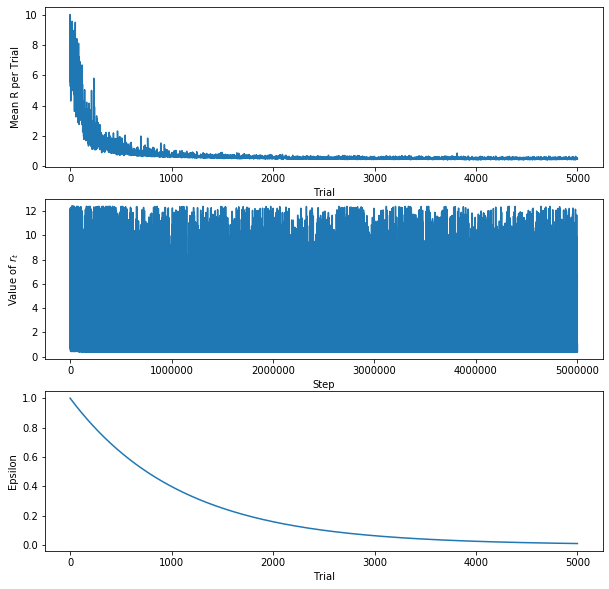

In [169]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

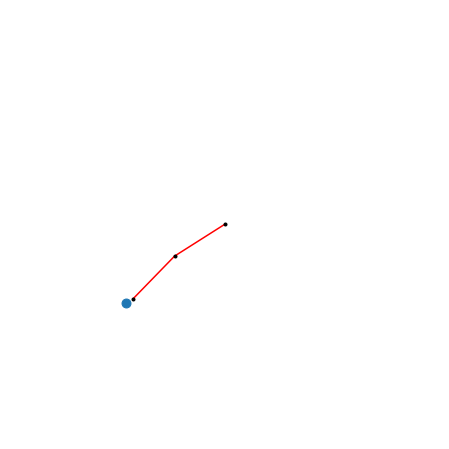

In [170]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

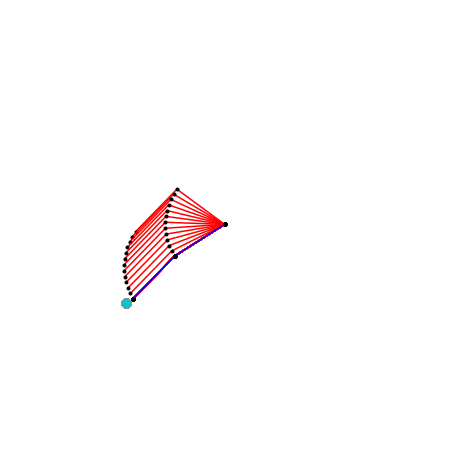

In [171]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

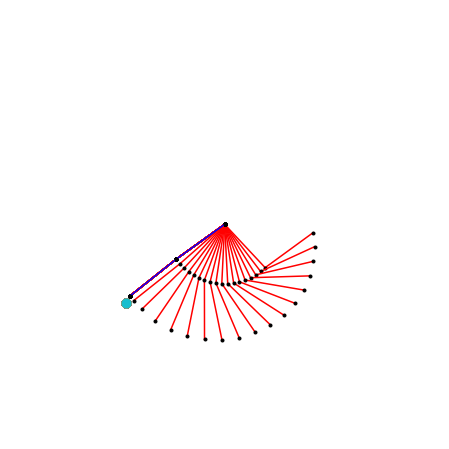

In [172]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 3

In [178]:
n_hiddens_list = [50, 10]
n_trials = 10000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 1000: Mean R 0.90
Trial 2000: Mean R 0.61
Trial 3000: Mean R 0.56
Trial 4000: Mean R 0.62
Trial 5000: Mean R 0.54
Trial 6000: Mean R 0.45
Trial 7000: Mean R 0.45
Trial 8000: Mean R 0.52
Trial 9000: Mean R 0.51
Trial 10000: Mean R 0.47


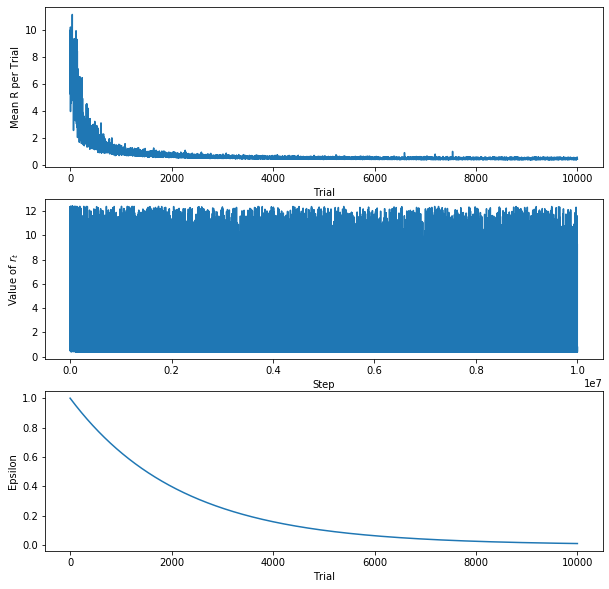

In [179]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

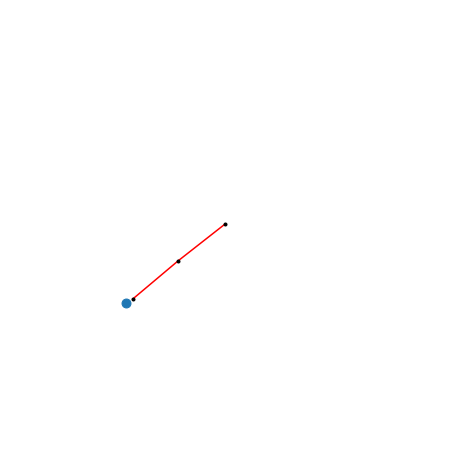

In [180]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

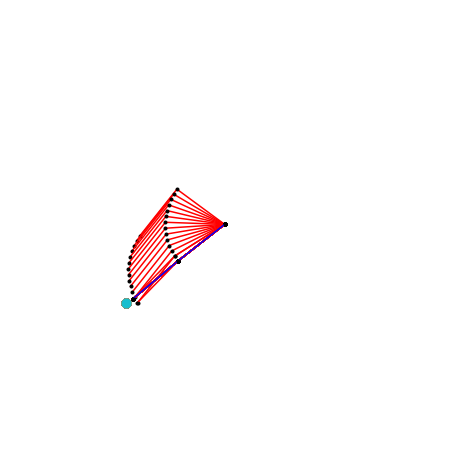

In [181]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

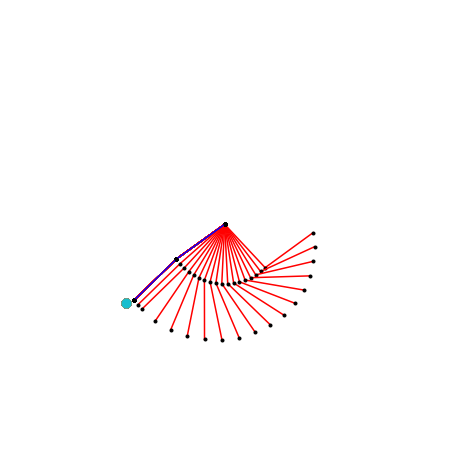

In [182]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

From the three experiment,the mean value gets closer to zero as number of trials. Thus, it has a big impact on the overall performance. 

In [198]:
import pandas as pd
data1=[["2000","0.56"],["5000","0.45"],["10000","0.47"]]
pd.DataFrame(data1, columns=["Number of trails","Mean value"])

,Number of trails,Mean value
0,2000,0.56
1,5000,0.45
2,10000,0.47


<BarContainer object of 3 artists>

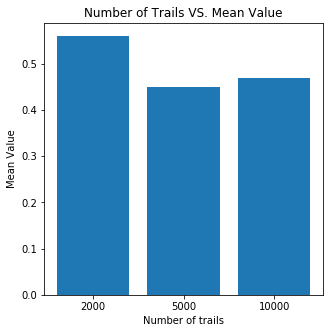

In [470]:
plt.figure(figsize=(5, 5))
plt.title('Number of Trails VS. Mean Value')
plt.xlabel('Number of trails')
plt.ylabel('Mean Value')
plt.bar(['2000','5000','10000'],[0.56,0.45,0.47])

##### 2.number of steps per trial

EXPERIMENT 1

In [199]:
n_hiddens_list = [50, 10]
n_trials = 2000
n_steps_per_trial = 100
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 200: Mean R 6.37
Trial 400: Mean R 1.04
Trial 600: Mean R 1.26
Trial 800: Mean R 1.33
Trial 1000: Mean R 0.60
Trial 1200: Mean R 0.49
Trial 1400: Mean R 0.76
Trial 1600: Mean R 1.14
Trial 1800: Mean R 0.56
Trial 2000: Mean R 0.97


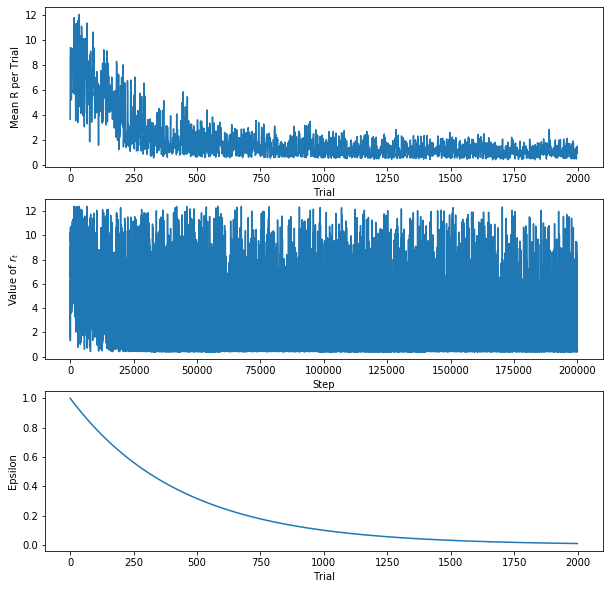

In [200]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

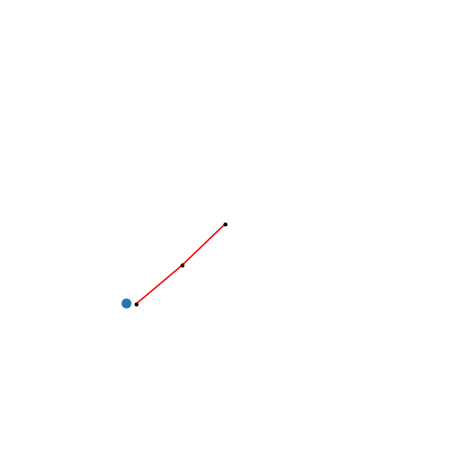

In [201]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

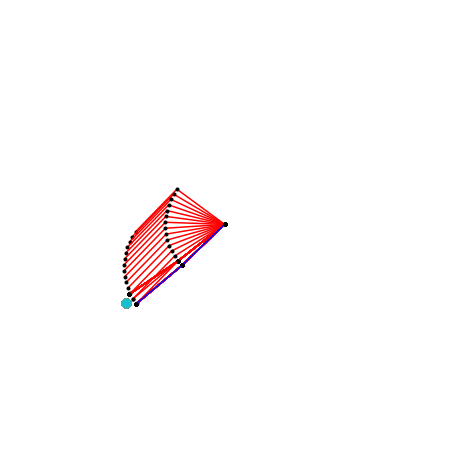

In [202]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

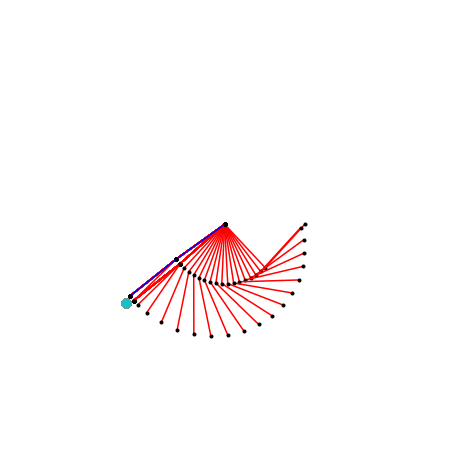

In [203]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 2

In [204]:
n_hiddens_list = [50, 10]
n_trials = 2000
n_steps_per_trial = 250
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 200: Mean R 1.21
Trial 400: Mean R 1.27
Trial 600: Mean R 0.81
Trial 800: Mean R 1.33
Trial 1000: Mean R 0.98
Trial 1200: Mean R 1.37
Trial 1400: Mean R 0.68
Trial 1600: Mean R 1.04
Trial 1800: Mean R 1.02
Trial 2000: Mean R 0.92


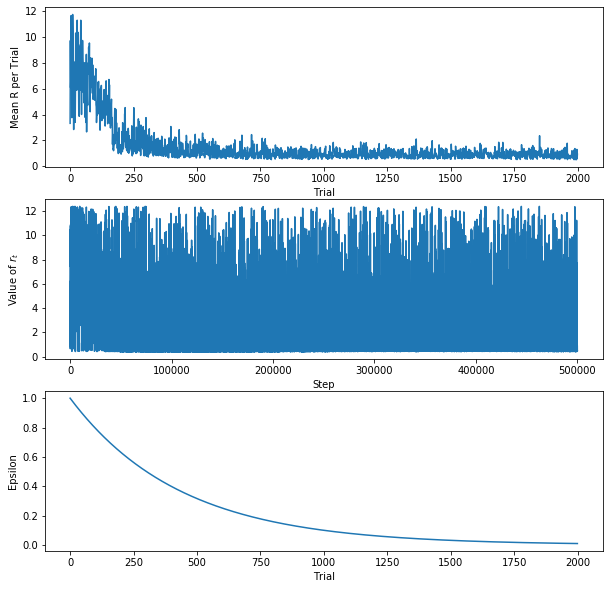

In [205]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

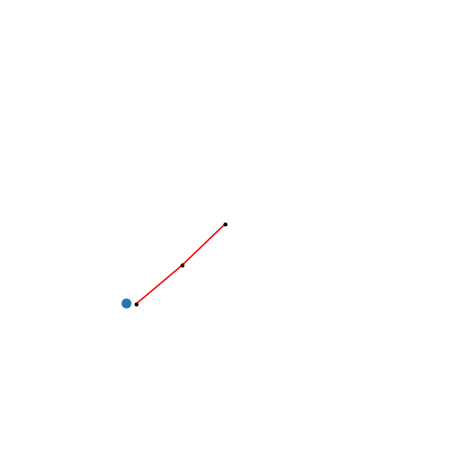

In [201]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

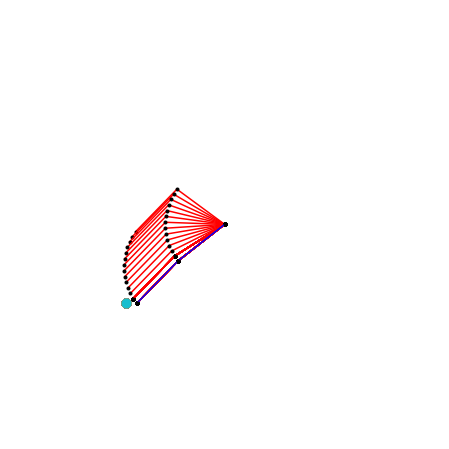

In [206]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

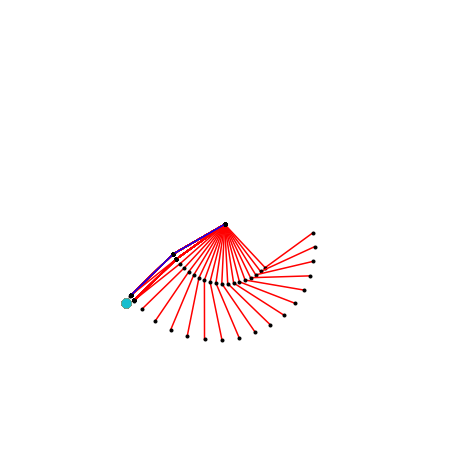

In [208]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 3

In [212]:
n_hiddens_list = [50, 10]
n_trials = 2000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 200: Mean R 1.17
Trial 400: Mean R 0.74
Trial 600: Mean R 0.80
Trial 800: Mean R 0.56
Trial 1000: Mean R 0.67
Trial 1200: Mean R 0.48
Trial 1400: Mean R 0.50
Trial 1600: Mean R 0.62
Trial 1800: Mean R 0.65
Trial 2000: Mean R 0.56


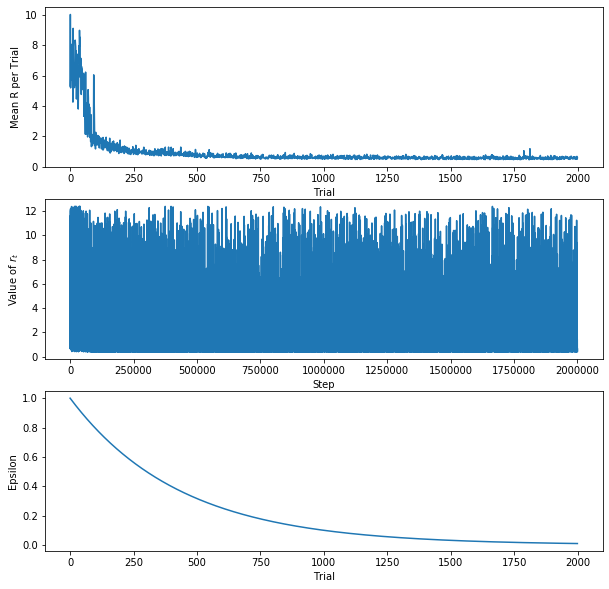

In [217]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

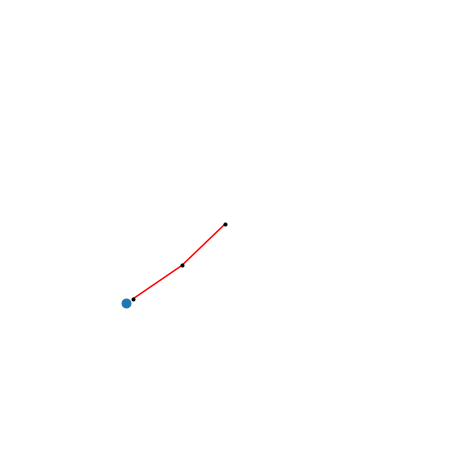

In [218]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

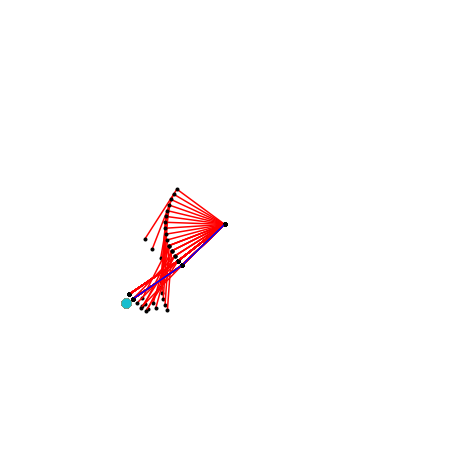

In [219]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

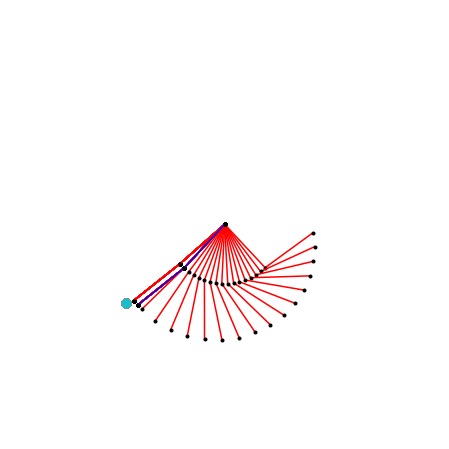

In [220]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

From the three experiment,the mean value gets closer to zero as number of steps per trial.But it is even more closer to one as the values are more than 0.5.Hence,it is necessary to have a higher number of trails and higher number of steps per trial in order to obatain a value close to zero.Thus,it has a big impact on the overall performance. 

In [210]:
import pandas as pd
data1=[["100","0.97"],["500","0.92"],["1000","0.56"]]
pd.DataFrame(data1, columns=["Number of steps per trail","Mean value"])

,Number of steps per trail,Mean value
0,100,0.97
1,500,0.92
2,1000,0.56


<BarContainer object of 3 artists>

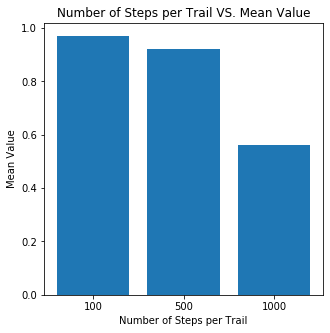

In [471]:
plt.figure(figsize=(5, 5))
plt.title('Number of Steps per Trail VS. Mean Value')
plt.xlabel('Number of Steps per Trail')
plt.ylabel('Mean Value')
plt.bar(['100','500','1000'],[0.97,0.92,0.56])

##### 3.number of SCG iterations in each train call

EXPERIMENT 1

In [221]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 8
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 6.29
Trial 40: Mean R 1.92
Trial 60: Mean R 0.71
Trial 80: Mean R 0.78
Trial 100: Mean R 0.57
Trial 120: Mean R 0.79
Trial 140: Mean R 0.81
Trial 160: Mean R 0.53
Trial 180: Mean R 1.26
Trial 200: Mean R 0.70


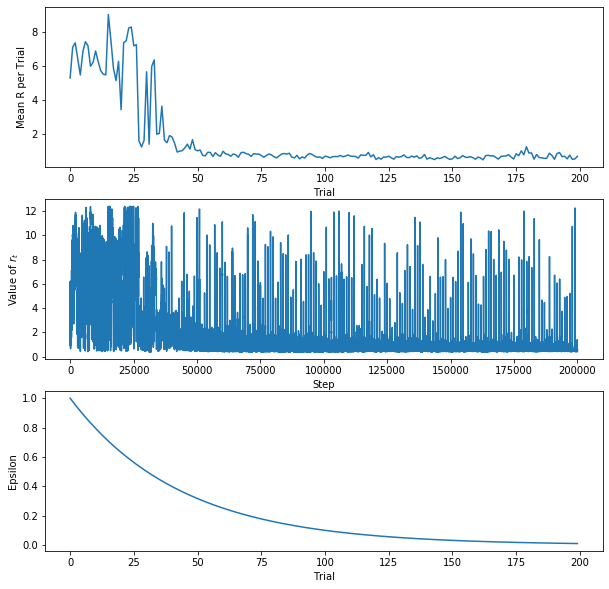

In [226]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

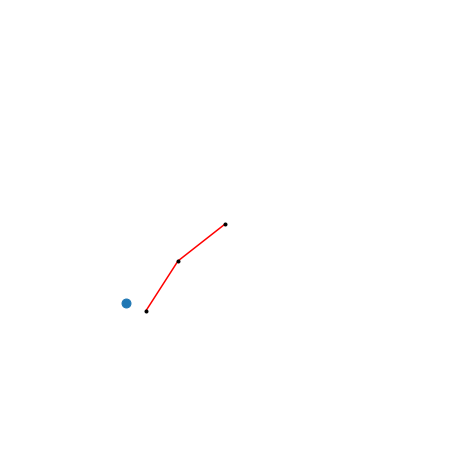

In [227]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

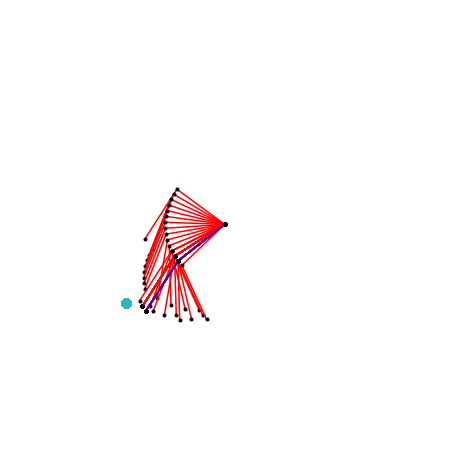

In [228]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

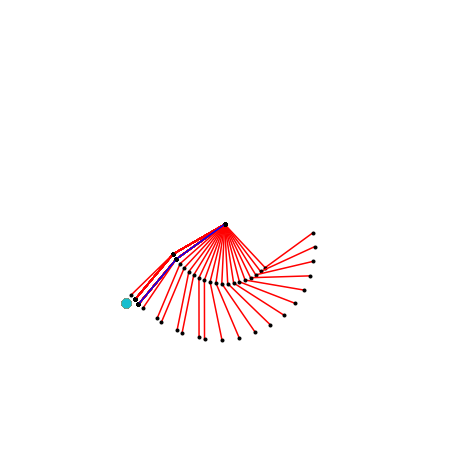

In [229]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 2

In [230]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 10
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 7.71
Trial 40: Mean R 1.12
Trial 60: Mean R 1.32
Trial 80: Mean R 0.99
Trial 100: Mean R 0.60
Trial 120: Mean R 0.97
Trial 140: Mean R 0.67
Trial 160: Mean R 0.53
Trial 180: Mean R 0.67
Trial 200: Mean R 0.75


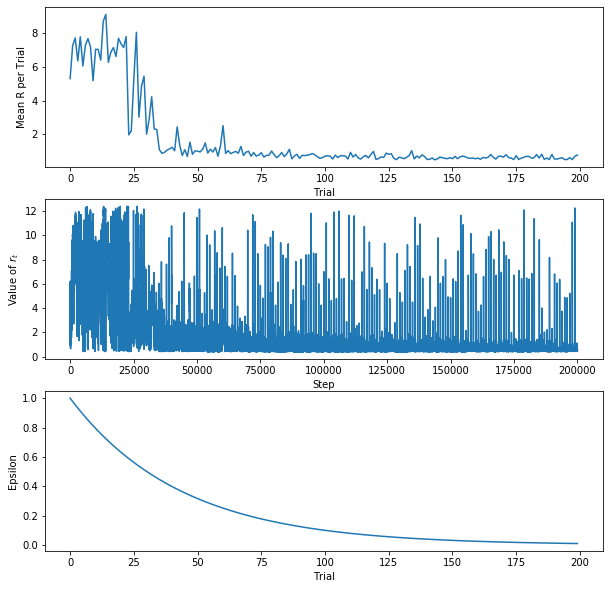

In [231]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

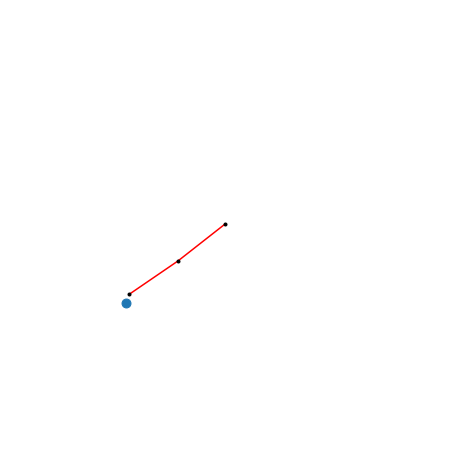

In [232]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

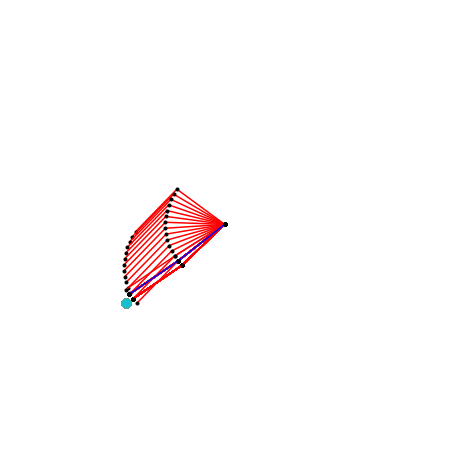

In [233]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

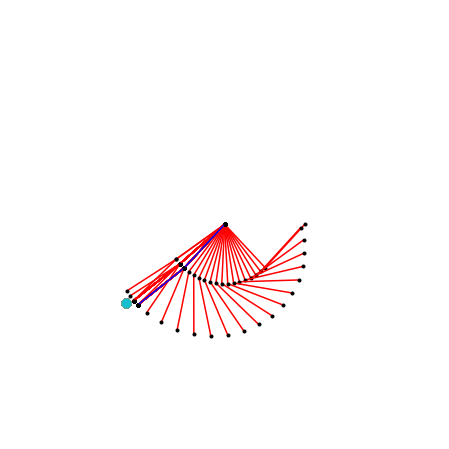

In [234]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 3

In [235]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 20
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 2.52
Trial 40: Mean R 1.02
Trial 60: Mean R 0.61
Trial 80: Mean R 0.65
Trial 100: Mean R 0.50
Trial 120: Mean R 0.65
Trial 140: Mean R 0.64
Trial 160: Mean R 0.60
Trial 180: Mean R 0.76
Trial 200: Mean R 0.73


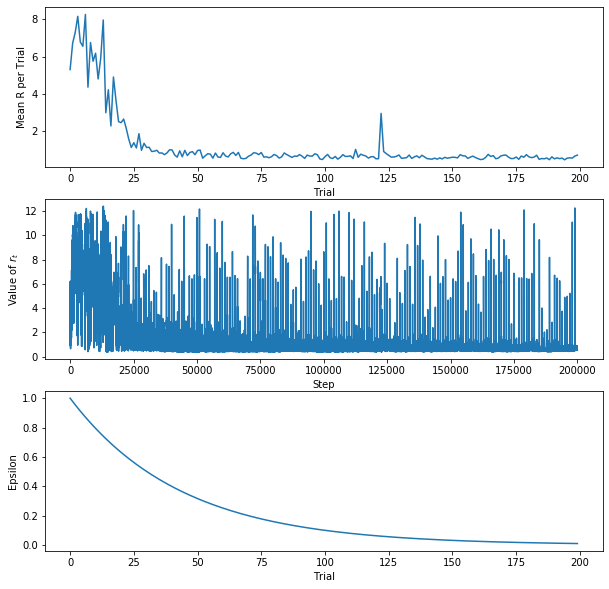

In [236]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

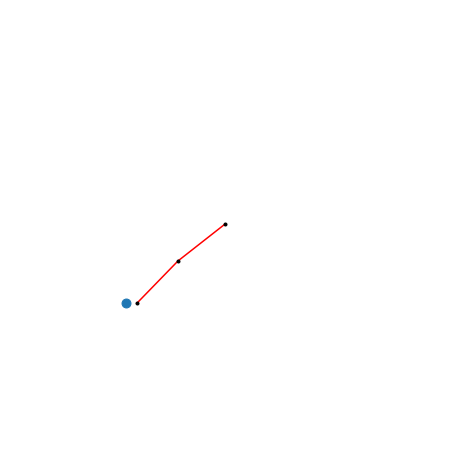

In [237]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

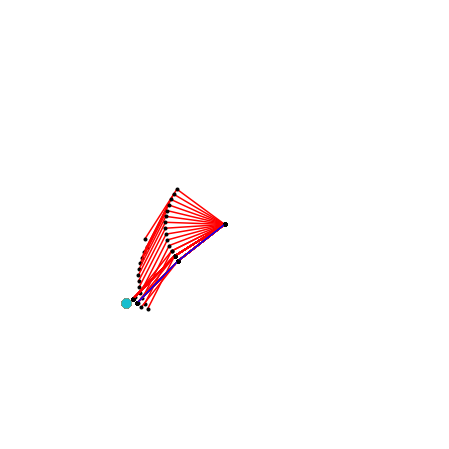

In [238]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

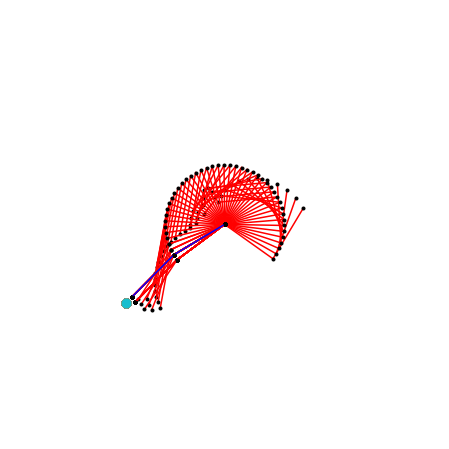

In [239]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

As the value of number of SCG iteration increases, there would not be any positive impact on the performance. Hence, it would be fine to have a lesser scg interation value.   

In [240]:
import pandas as pd
data1=[["8","0.70"],["10","0.75"],["20","0.73"]]
pd.DataFrame(data1, columns=["Number of SCG Iterations in each train call","Mean value"])

,Number of SCG Iterations in each train call,Mean value
0,8,0.70
1,10,0.75
2,20,0.73


<BarContainer object of 3 artists>

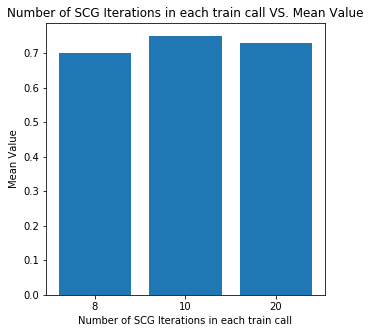

In [472]:
plt.figure(figsize=(5, 5))
plt.title('Number of SCG Iterations in each train call VS. Mean Value')
plt.xlabel('Number of SCG Iterations in each train call')
plt.ylabel('Mean Value')
plt.bar(['8','10','20'],[0.70,0.75,0.73])

##### 4. Gamma

EXPERIMENT 1

In [241]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 1.0

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 7.38
Trial 40: Mean R 3.87
Trial 60: Mean R 7.16
Trial 80: Mean R 7.09
Trial 100: Mean R 7.06
Trial 120: Mean R 7.08
Trial 140: Mean R 7.18
Trial 160: Mean R 7.18
Trial 180: Mean R 7.05
Trial 200: Mean R 7.04


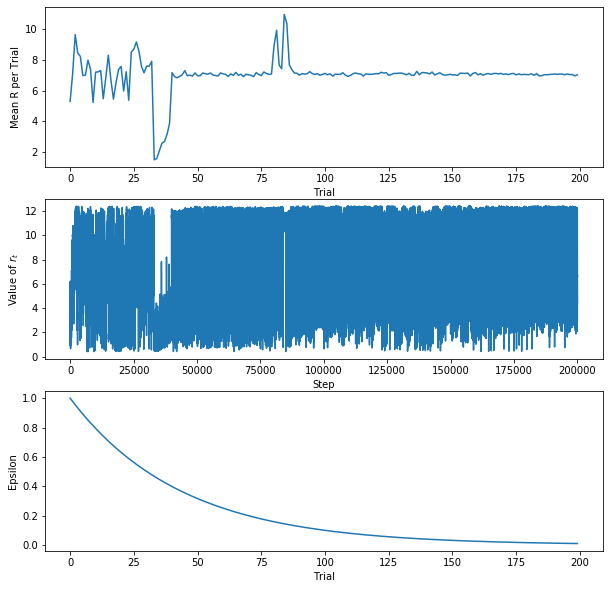

In [242]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

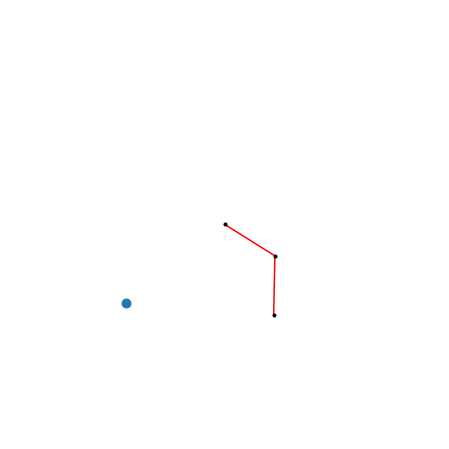

In [243]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

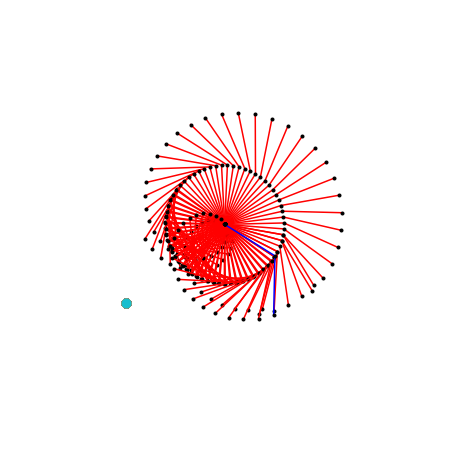

In [244]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

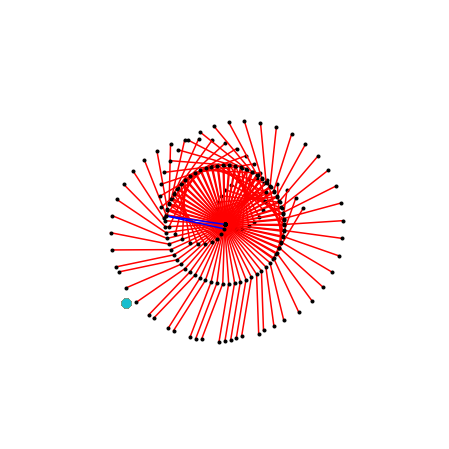

In [245]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 2

In [264]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 8.55
Trial 40: Mean R 7.17
Trial 60: Mean R 7.38
Trial 80: Mean R 7.23
Trial 100: Mean R 3.78
Trial 120: Mean R 1.78
Trial 140: Mean R 1.19
Trial 160: Mean R 1.26
Trial 180: Mean R 1.32
Trial 200: Mean R 0.90


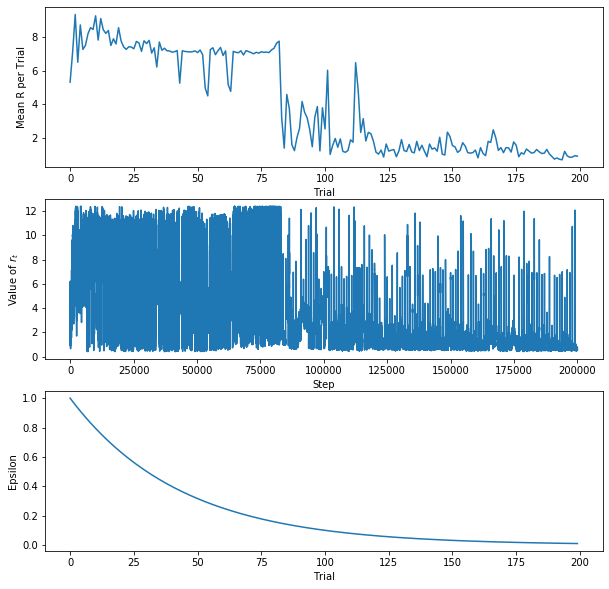

In [265]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

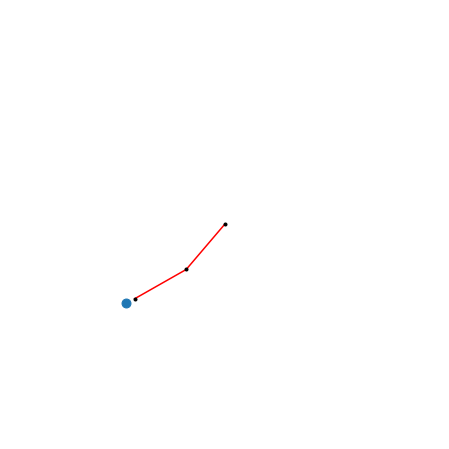

In [266]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

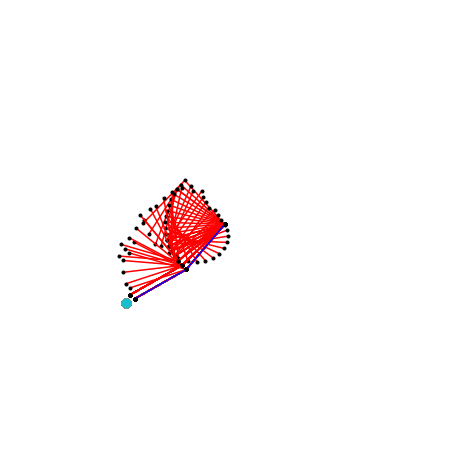

In [267]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

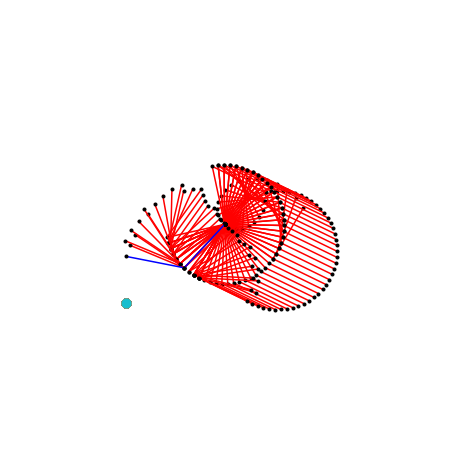

In [268]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 3

In [259]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.1

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 6.83
Trial 40: Mean R 6.78
Trial 60: Mean R 3.87
Trial 80: Mean R 3.17
Trial 100: Mean R 2.97
Trial 120: Mean R 4.46
Trial 140: Mean R 0.91
Trial 160: Mean R 1.43
Trial 180: Mean R 0.75
Trial 200: Mean R 1.67


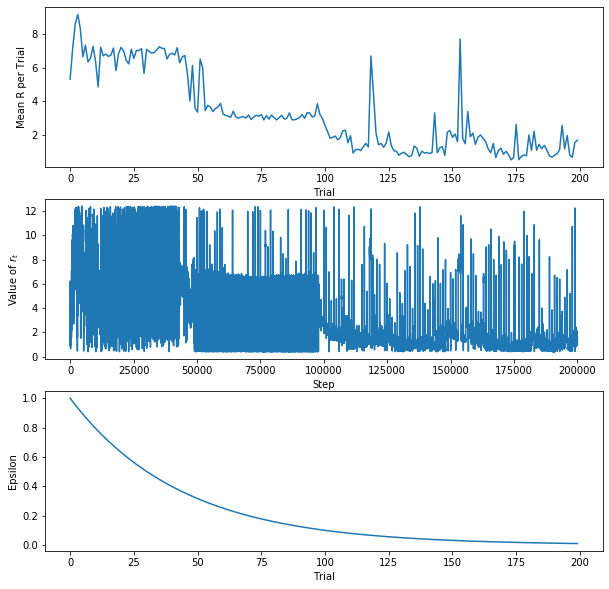

In [260]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

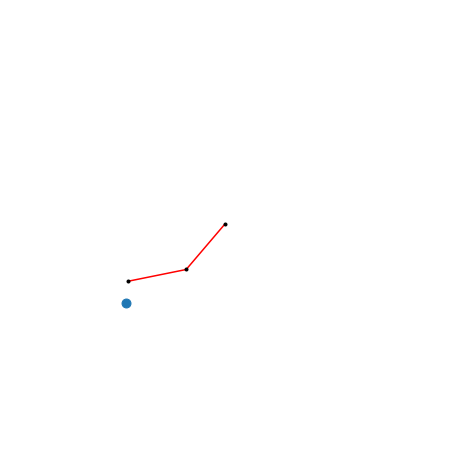

In [261]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

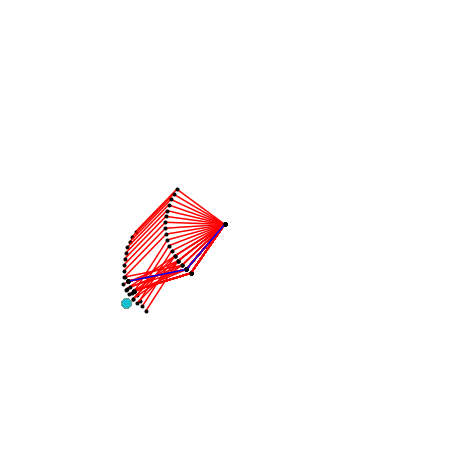

In [262]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

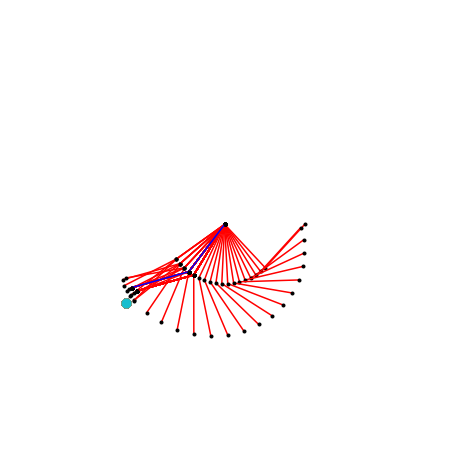

In [263]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

From the experiment, if the gamma value is high , the chances of going to zero will be less. Thus it is smaking a significant imoact on the performance. So, it is necessasry to have a gamma value less but not more than 1, which makes the values go higher. 

In [269]:
import pandas as pd
data1=[["1","7.04"],["0.9","0.90"],["0.1","1.67"]]
pd.DataFrame(data1, columns=["Gamma Values","Mean value"])

,Gamma Values,Mean value
0,1,7.04
1,0.9,0.90
2,0.1,1.67


<BarContainer object of 3 artists>

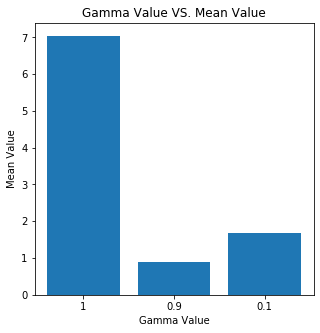

In [473]:
plt.figure(figsize=(5, 5))
plt.title('Gamma Value VS. Mean Value')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Value')
plt.bar(['1','0.9','0.1'],[7.04,0.90,1.67])

##### 5. Number of hidden list

EXPERIMENT 1

In [295]:
n_hiddens_list = [50,10,10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 7.53
Trial 40: Mean R 4.87
Trial 60: Mean R 5.40
Trial 80: Mean R 1.73
Trial 100: Mean R 3.00
Trial 120: Mean R 1.77
Trial 140: Mean R 1.71
Trial 160: Mean R 0.99
Trial 180: Mean R 1.20
Trial 200: Mean R 0.89


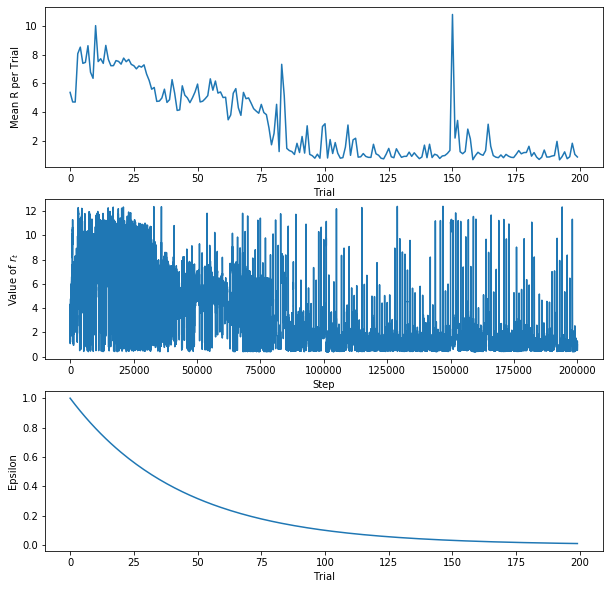

In [296]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

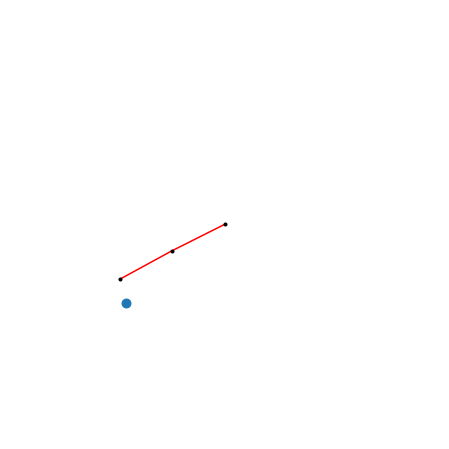

In [297]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

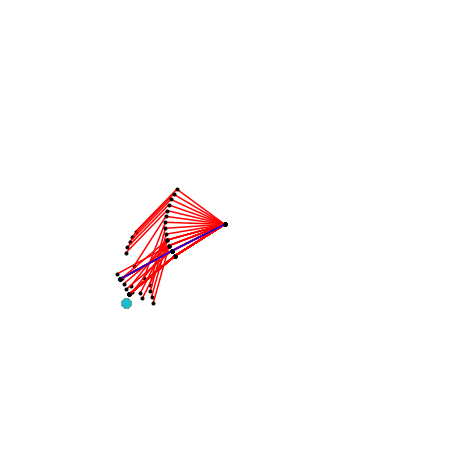

In [298]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

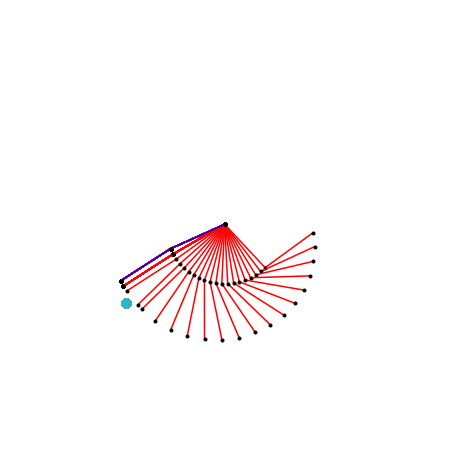

In [299]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 2

In [300]:
n_hiddens_list = [100]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 7.14
Trial 40: Mean R 4.51
Trial 60: Mean R 3.87
Trial 80: Mean R 1.06
Trial 100: Mean R 0.87
Trial 120: Mean R 0.79
Trial 140: Mean R 0.85
Trial 160: Mean R 1.34
Trial 180: Mean R 1.04
Trial 200: Mean R 1.06


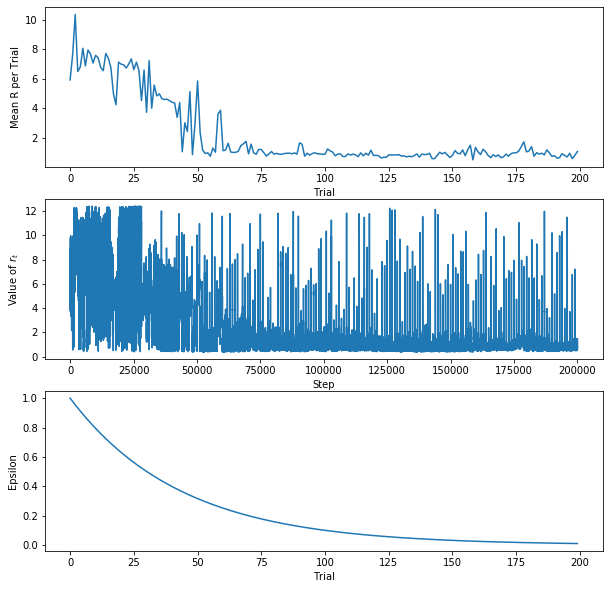

In [301]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

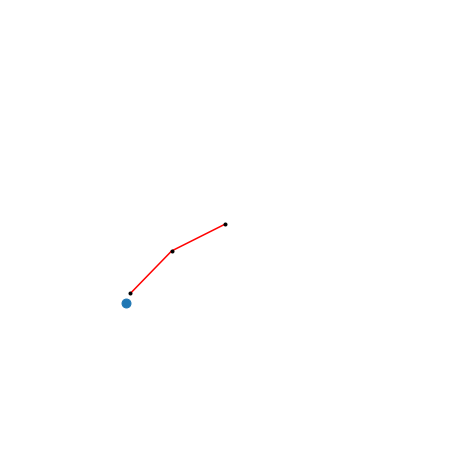

In [302]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

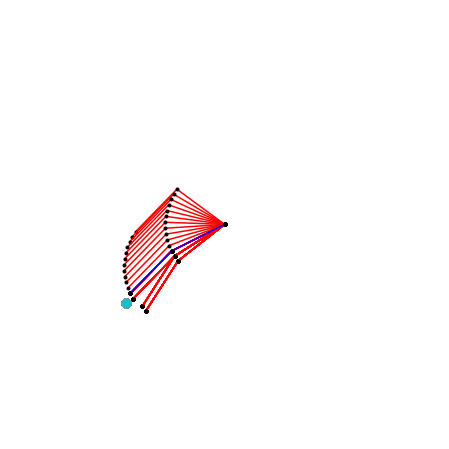

In [303]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

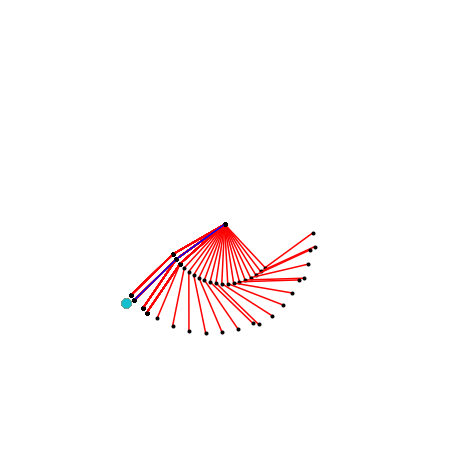

In [304]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

EXPERIMENT 3

In [305]:
n_hiddens_list = [25,25]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 5.48
Trial 40: Mean R 6.05
Trial 60: Mean R 1.56
Trial 80: Mean R 0.97
Trial 100: Mean R 4.86
Trial 120: Mean R 0.89
Trial 140: Mean R 0.65
Trial 160: Mean R 1.11
Trial 180: Mean R 1.33
Trial 200: Mean R 1.39


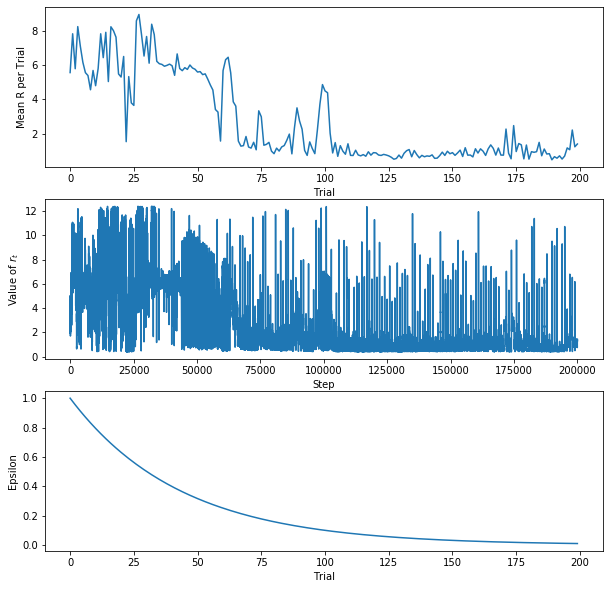

In [306]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

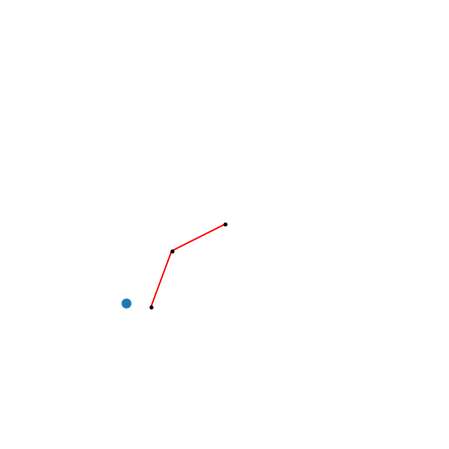

In [307]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

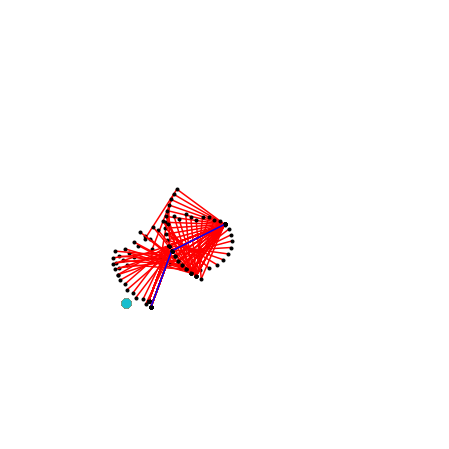

In [308]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

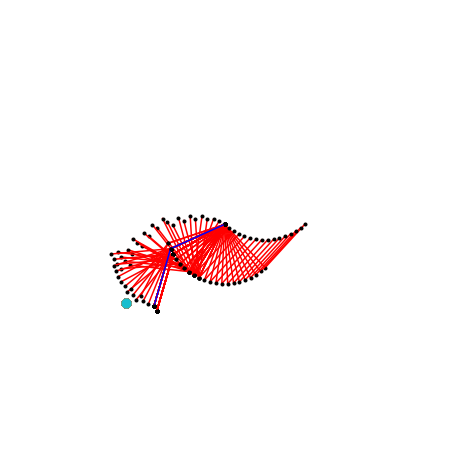

In [310]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

From the experiment, adding more hidden layers would make the mean value go higher, which does not have a significant effect.As the number of hidden layer increase, the mean value increases because difference in initial weights lead to difference local minima, thus leads to more number of neurons than required. 

In [311]:
import pandas as pd
data1=[["[50,10,10]","0.89"],["[100]","1.06"],["[25,25]","1.39"]]
pd.DataFrame(data1, columns=["Hiddens Layers","Mean value"])

,Hiddens Layers,Mean value
0,"[50,10,10]",0.89
1,[100],1.06
2,"[25,25]",1.39


<BarContainer object of 3 artists>

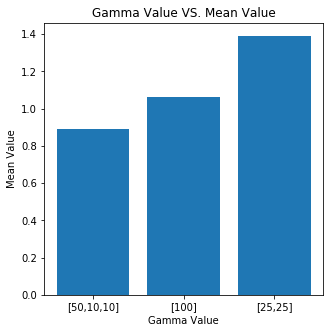

In [474]:
plt.figure(figsize=(5, 5))
plt.title('Gamma Value VS. Mean Value')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Value')
plt.bar(['[50,10,10]','[100]','[25,25]'],[0.89,1.06,1.39])

#### GOOD PARAMETERS

For getting a good value parameters, we have to increase the number of trails with two number of hidden layers and less scg interation value with 0.9 as gamma value.

In [312]:
n_hiddens_list = [100, 100]
n_trials = 20000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.1

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 2000: Mean R 0.79
Trial 4000: Mean R 0.67
Trial 6000: Mean R 0.54
Trial 8000: Mean R 0.46
Trial 10000: Mean R 0.60
Trial 12000: Mean R 0.60
Trial 14000: Mean R 0.51
Trial 16000: Mean R 0.65
Trial 18000: Mean R 0.58
Trial 20000: Mean R 0.58


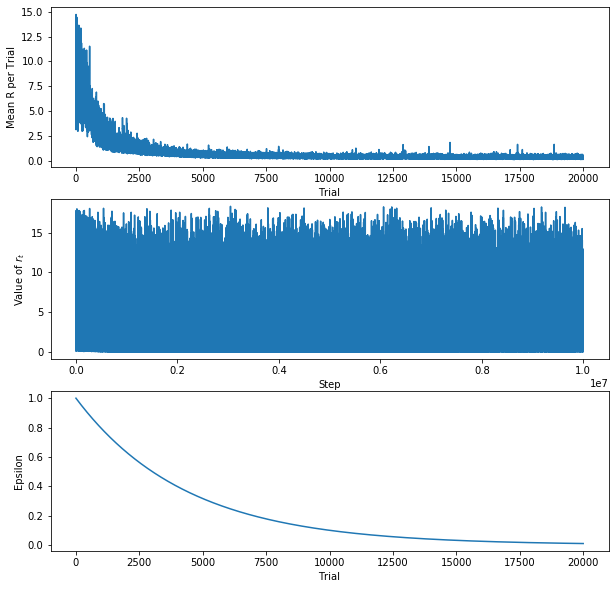

In [463]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [467]:
import pandas as pd
data1=[["Number of Trails","20000"],["[Number of steps per trail","1000"],["Gamma","0.1"],["Hidden Layers","[100,100]"],["Number of SCG Iterations in each train call","4"]]
pd.DataFrame(data1, columns=["Good parameter values","Values"])

,Good parameter values,Values
0,Number of Trails,20000
1,[Number of steps per trail,1000
2,Gamma,0.1
3,Hidden Layers,"[100,100]"
4,Number of SCG Iterations in each train call,4


## Create robot with four links of lengths, 4, 3, 3,  and 2.

Again, find good values for the parameters. 

In [455]:
single_joint_actions = [-0.1, 0, 0.1] #Set of actions for the whole robot that has every combinations of these numbers for each joint. 
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links))) #Iertools_Product is like a cartesian product 

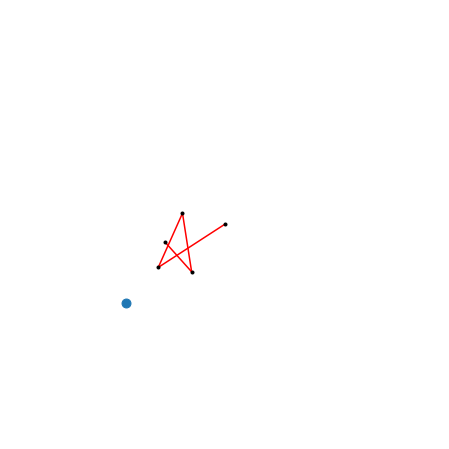

In [456]:
robot=Robot([4.,3.,3.,2.])
robot.set_goal([5.,6.])
robot.animate(100)

In [461]:
n_hiddens_list = [100,100]
n_trials = 20000
n_steps_per_trial = 500
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 2000: Mean R 0.93
Trial 4000: Mean R 1.10
Trial 6000: Mean R 0.26
Trial 8000: Mean R 0.36
Trial 10000: Mean R 0.58
Trial 12000: Mean R 0.40
Trial 14000: Mean R 0.36
Trial 16000: Mean R 0.29
Trial 18000: Mean R 0.34
Trial 20000: Mean R 0.20


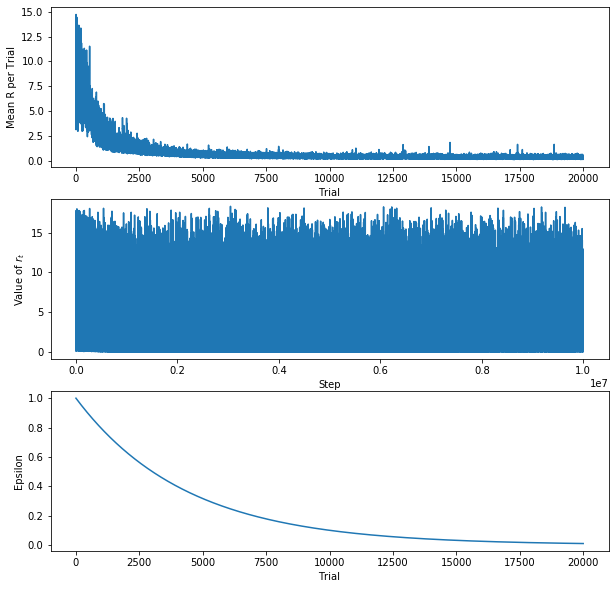

In [463]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [ ]:
n_hiddens_list = [100,100,100]
n_trials = 18000
n_steps_per_trial = 500
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 2000: Mean R 1.61
Trial 4000: Mean R 1.04
Trial 6000: Mean R 0.40
Trial 8000: Mean R 0.41
Trial 10000: Mean R 0.34
Trial 12000: Mean R 0.41
Trial 14000: Mean R 0.24
Trial 16000: Mean R 0.57
Trial 18000: Mean R 0.53


From the above experiments, the mean value gets closer to zero when we increase the number of trails with minimal value of  number of hidden layers and less scg interation value with 0.9 as gamma value.

In [515]:
import pandas as pd
data1=[["Number of Trails","20000"],["[Number of steps per trail","500"],["Gamma","0.9"],["Hidden Layers","[100,100]"],["Number of SCG Iterations in each train call","4"]]
pd.DataFrame(data1, columns=["Good parameter values","Values"])

,Good parameter values,Values
0,Number of Trails,20000
1,[Number of steps per trail,500
2,Gamma,0.9
3,Hidden Layers,"[100,100]"
4,Number of SCG Iterations in each train call,4


## Increase number of valid actions

We have been using just three different actions for each joint, `[-0.1, 0, 0.1]`.  Allow more precision in the control by changing this list of valid actions for each joint to `[-0.1, -0.05, 0, 0.05, 0.1]`.

As before, find good values for the parameters.

In [490]:
single_joint_actions = [-0.1, -0.05, 0, 0.05, 0.1] #Set of actions for the whole robot that has every combinations of these numbers for each joint. 
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links))) #Iertools_Product is like a cartesian product 

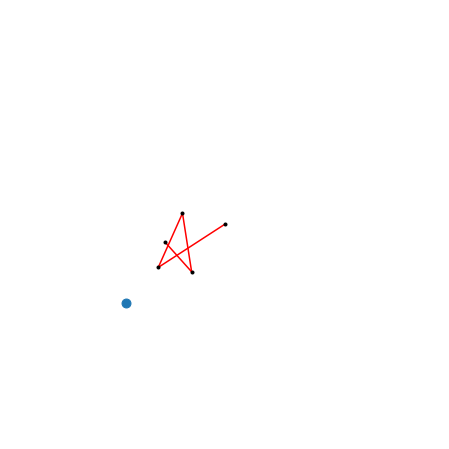

In [491]:
robot=Robot([4.,3.,3.,2.])
robot.set_goal([5.,6.])
robot.animate(100)

In [512]:
n_hiddens_list = [100,100]
n_trials = 2000
n_steps_per_trial = 800

n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 200: Mean R 5.97
Trial 400: Mean R 1.35
Trial 600: Mean R 0.77
Trial 800: Mean R 1.11
Trial 1000: Mean R 0.77
Trial 1200: Mean R 0.86
Trial 1400: Mean R 0.74
Trial 1600: Mean R 0.83
Trial 1800: Mean R 0.63
Trial 2000: Mean R 5.31


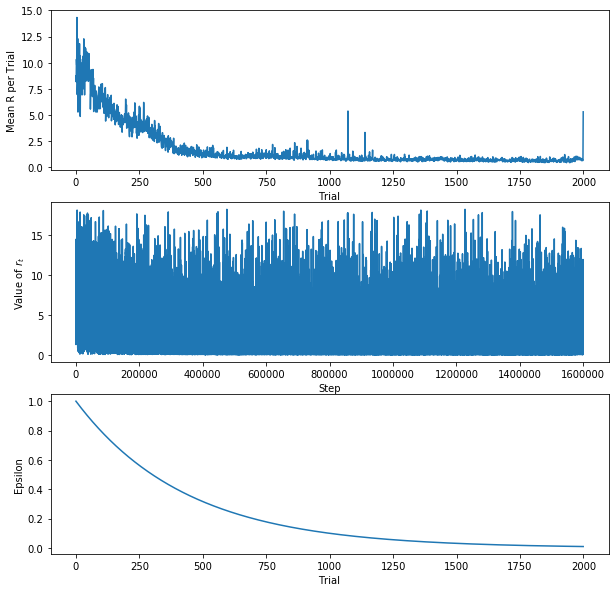

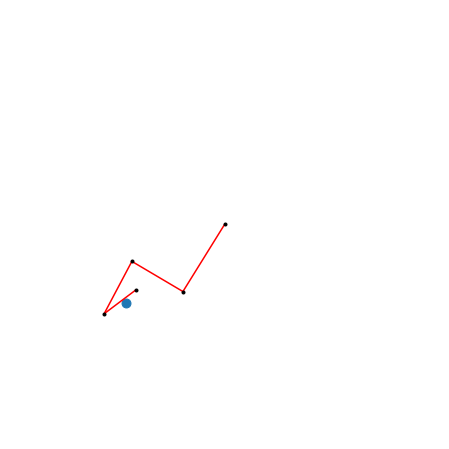

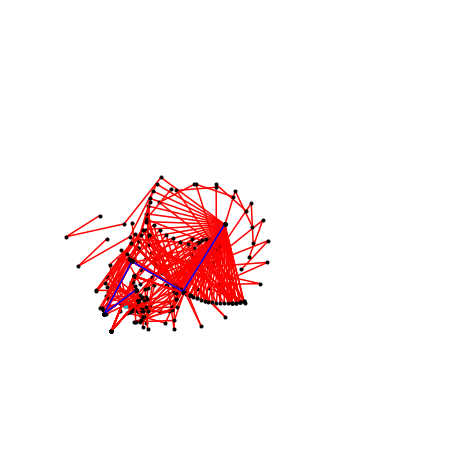

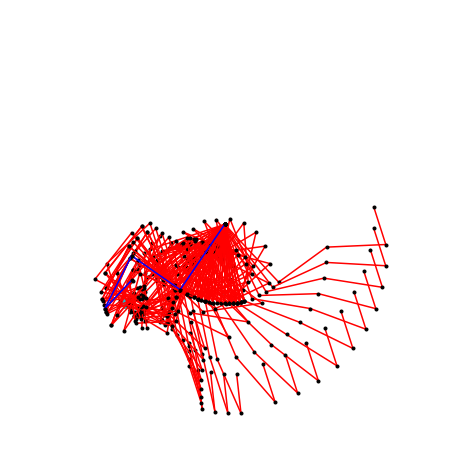

In [513]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

In [ ]:
n_hiddens_list = [100,100]
n_trials = 18000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 2000: Mean R 1.61
Trial 4000: Mean R 1.04
Trial 6000: Mean R 0.40
Trial 8000: Mean R 0.41
Trial 10000: Mean R 0.34
Trial 12000: Mean R 0.41
Trial 14000: Mean R 0.24
Trial 16000: Mean R 0.57
Trial 18000: Mean R 0.53


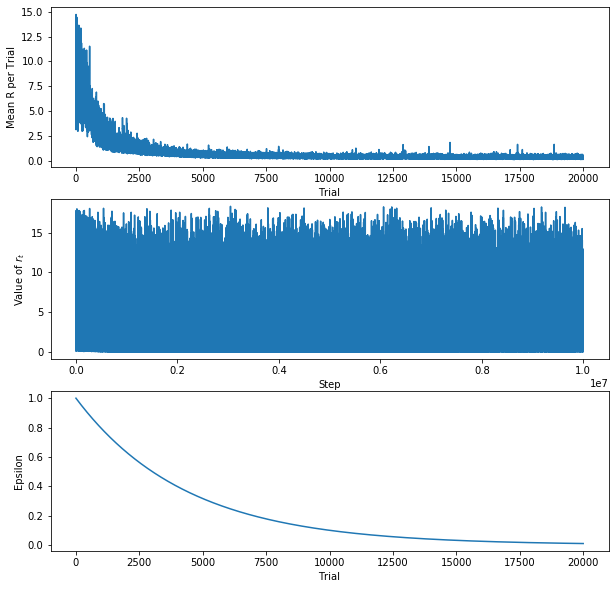

In [463]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [39]:
n_hiddens_list = [100]
n_trials = 20000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 2000: Mean R 1.19
Trial 4000: Mean R 0.96
Trial 6000: Mean R 0.89
Trial 8000: Mean R 0.89
Trial 10000: Mean R 0.83
Trial 12000: Mean R 0.98
Trial 14000: Mean R 0.88
Trial 16000: Mean R 0.83
Trial 18000: Mean R 0.94
Trial 20000: Mean R 0.92


In [ ]:
n_hiddens_list = [100,100]
n_trials = 18000
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

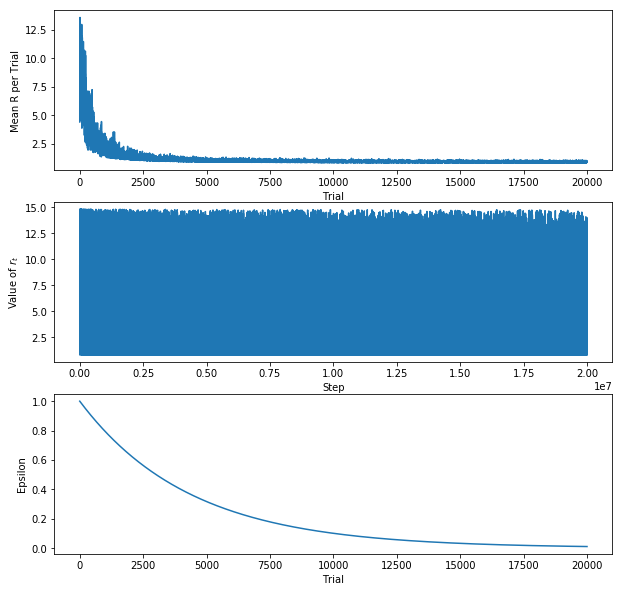

In [40]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [ ]:
n_hiddens_list = [100,100,100,100]
n_trials = 20000
n_steps_per_trial = 500
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)

Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 2000: Mean R 1.13
Trial 4000: Mean R 0.61
Trial 6000: Mean R 0.72
Trial 8000: Mean R 0.47
Trial 10000: Mean R 0.68
Trial 12000: Mean R 0.55
Trial 14000: Mean R 0.66
Trial 16000: Mean R 0.50
Trial 18000: Mean R 0.56
Trial 20000: Mean R 0.42


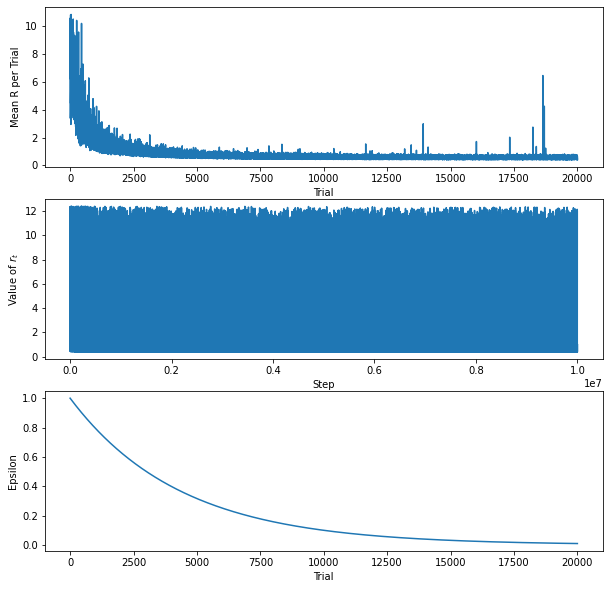

In [ ]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

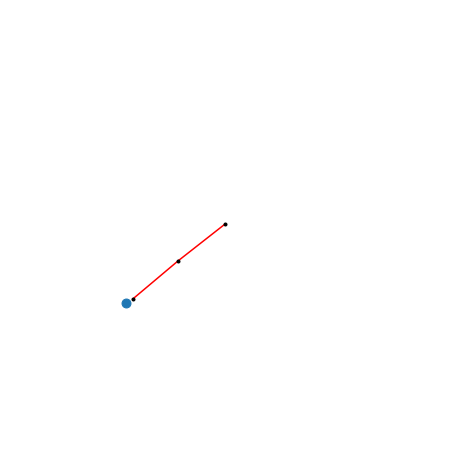

In [ ]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

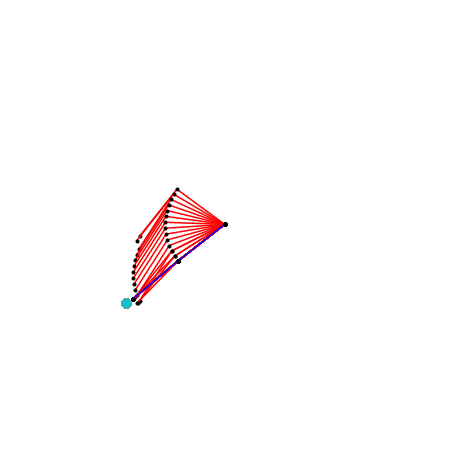

In [ ]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

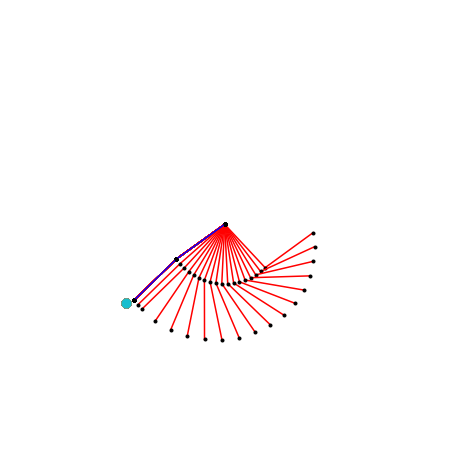

In [ ]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

In [519]:
import pandas as pd
data1=[["Number of Trails","18000"],["Number of steps per trail","1000"],["Gamma","0.9"],["Hidden Layers","[100,100]"],["Number of SCG Iterations in each train call","4"]]
pd.DataFrame(data1, columns=["Good parameter values","Values"])

,Good parameter values,Values
0,Number of Trails,18000
1,Number of steps per trail,1000
2,Gamma,0.9
3,Hidden Layers,"[100,100]"
4,Number of SCG Iterations in each train call,4


### OBSERVATIONS

Neural Network has been an important field in digital domains like computer vision and natural language processing. First, I have utilized neural network using n-hidden layer and sigmod function. Then we have utilized sgd optimization in order to get that correct dynamics of the robot arm. From all the observations,we got to know the most significant parameter is number of trails as increase in value would provide an accuracy close to zero. Thus, it shows us that the number of trails can help us get closer to the goal. 

In [518]:
import pandas as pd
data1=[["1","20000","500","0.9","[100,100]","4"],["2","20000","500","0.9","[100,100]","4"],["3","18000","1000","0.9","[100,100]","4"]]
pd.DataFrame(data1, columns=["Experiment Number","Number of Trails","Number of steps per trail","Gamma","Hidden Layers","Number of SCG Iterations in each train call"])

,Experiment Number,Number of Trails,Number of steps per trail,Gamma,Hidden Layers,Number of SCG Iterations in each train call
0,1,20000,500,0.9,"[100,100]",4
1,2,20000,500,0.9,"[100,100]",4
2,3,18000,1000,0.9,"[100,100]",4


# Thread to validity

As the value of the number of trails is so high, the training time normally took about 21600 seconds. n order to get those results, either we can run it on a cluster or using gpu. 